In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import category_encoders as ce

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# data upload

In [79]:
df = pd.read_csv("train.csv")
print(df.shape)
df.info()

(1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 1

In [80]:
target = "SalePrice"
objectives = [c for c in df if (df[c].dtype.str in '|O')&(c != target)]
numericals = [c for c in df if (df[c].dtype.str in ['<i8', '<f8'])&(c != target)]
print(
    f"no of objective features: {len(objectives)}\n"
    f"no of numerical features: {len(numericals)}\n"
    f"target columns: '{target}'"
)

no of objective features: 43
no of numerical features: 37
target columns: 'SalePrice'


## check empty values within the dataframe

In [81]:
def check_empties(df):
    '''check empty values within a dataframe'''
    empties = {}
    for f in df:
        na = df[f].isna().sum()
        if na > 0:
            # print(f"feature {f}: {na}, that is {na/len(df)*100:.2f}%")
            empties[f] = (na,  f"{na/len(df)*100:.2f}%")
        
    return empties

empties = check_empties(df)
empties

{'LotFrontage': (259, '17.74%'),
 'Alley': (1369, '93.77%'),
 'MasVnrType': (8, '0.55%'),
 'MasVnrArea': (8, '0.55%'),
 'BsmtQual': (37, '2.53%'),
 'BsmtCond': (37, '2.53%'),
 'BsmtExposure': (38, '2.60%'),
 'BsmtFinType1': (37, '2.53%'),
 'BsmtFinType2': (38, '2.60%'),
 'Electrical': (1, '0.07%'),
 'FireplaceQu': (690, '47.26%'),
 'GarageType': (81, '5.55%'),
 'GarageYrBlt': (81, '5.55%'),
 'GarageFinish': (81, '5.55%'),
 'GarageQual': (81, '5.55%'),
 'GarageCond': (81, '5.55%'),
 'PoolQC': (1453, '99.52%'),
 'Fence': (1179, '80.75%'),
 'MiscFeature': (1406, '96.30%')}

## process numerical features

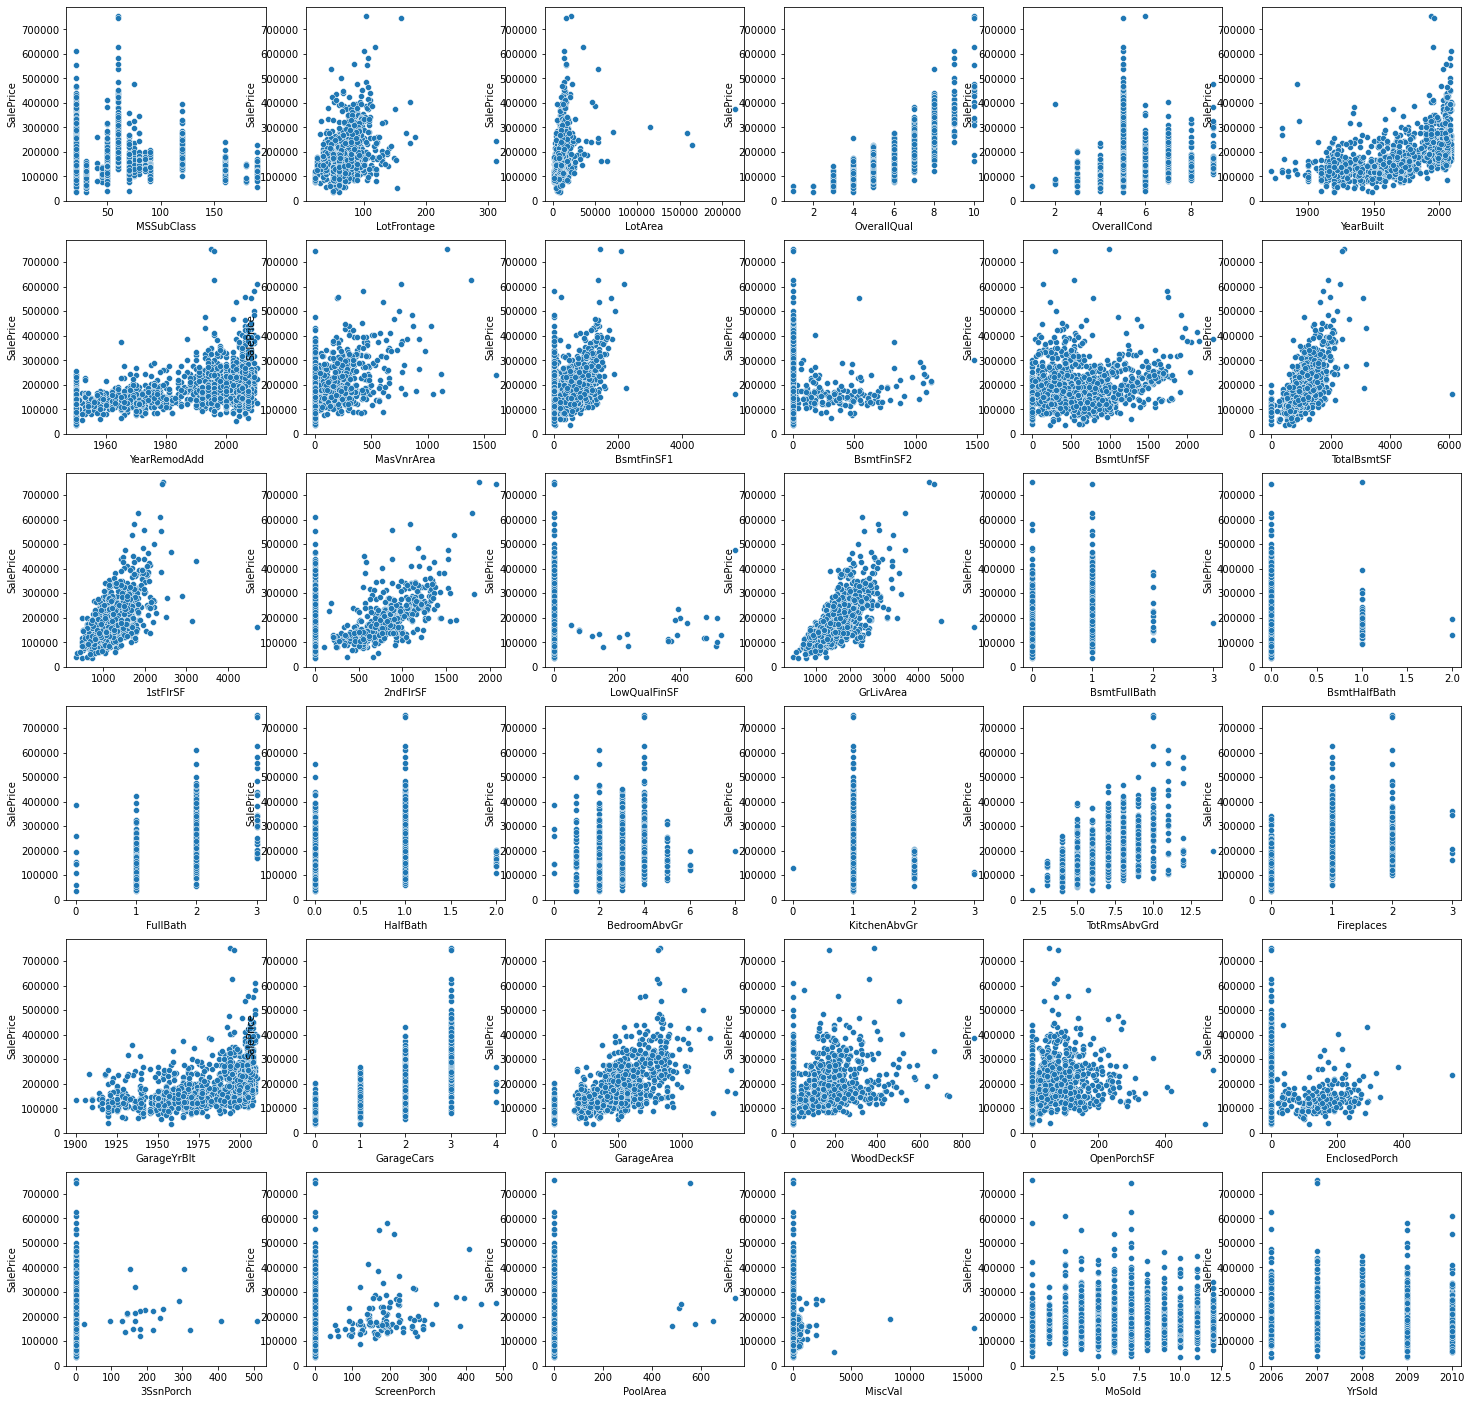

In [82]:
# check a numeric feature dependency to the target
fig, axs = plt.subplots(nrows=int(len(numericals)**0.5), ncols=int(len(numericals)**0.5), figsize=(25,25));
for i in range(len(numericals)-1):
    sns.scatterplot(
        data=df[[numericals[i+1]]+[target]], 
        x=numericals[i+1], y=target, ax=axs[i//int(len(numericals)**0.5), i%int(len(numericals)**0.5)]
    );

In [83]:
empty_numericals = [x for x in empties.keys() if x in numericals]
{k:v for k,v in empties.items() if k in numericals}

{'LotFrontage': (259, '17.74%'),
 'MasVnrArea': (8, '0.55%'),
 'GarageYrBlt': (81, '5.55%')}

The following features have quite an intense linear relationship to the target:
- 'OverallQual',
- 'TotalBsmtSF',
- '1stFlrSF'
- '2ndFlrSF'
- 'GrLivArea'
- 'GarageArea'

The numeric columns that have missing values have medium to strong relationship to the target, are 'LotFrontage', thus it makes sense to apply the lingreg model to predict nan values for them. 

The 'MasVnrArea' will be filled with the simmple mean.

'GarageYrBlt' appears to be numeric only technically, by semantic value it is the categorical feature. The nan valeus will be filled with the simple mode.

The 'Id' is removed from the features as well.

In [84]:
numericals.remove("Id")

In [85]:
df.GarageYrBlt = df.GarageYrBlt.fillna(df.GarageYrBlt.mode().values[0])
df.GarageYrBlt = df.GarageYrBlt.astype(int).astype(str)
numericals = [x for x in numericals if x != "GarageYrBlt"]
objectives += ["GarageYrBlt"]

In [86]:
df.MasVnrArea = df.MasVnrArea.fillna(df.MasVnrArea.mean())

In [87]:
linreg = LinearRegression()
idx = df[df.LotFrontage.isna()].index
linreg.fit(
    df[~df.index.isin(idx)][[x for x in numericals if x not in ['LotFrontage']]], 
    df[~df.index.isin(idx)].LotFrontage
)
df.loc[df.index.isin(idx), "LotFrontage"] = linreg.predict(
    df[df.index.isin(idx)][[x for x in numericals if x not in ['LotFrontage']]]
)

## process objects

In [88]:
empty_objects = [x for x in empties.keys() if x in objectives]
{k:v for k,v in empties.items() if k in objectives}

{'Alley': (1369, '93.77%'),
 'MasVnrType': (8, '0.55%'),
 'BsmtQual': (37, '2.53%'),
 'BsmtCond': (37, '2.53%'),
 'BsmtExposure': (38, '2.60%'),
 'BsmtFinType1': (37, '2.53%'),
 'BsmtFinType2': (38, '2.60%'),
 'Electrical': (1, '0.07%'),
 'FireplaceQu': (690, '47.26%'),
 'GarageType': (81, '5.55%'),
 'GarageYrBlt': (81, '5.55%'),
 'GarageFinish': (81, '5.55%'),
 'GarageQual': (81, '5.55%'),
 'GarageCond': (81, '5.55%'),
 'PoolQC': (1453, '99.52%'),
 'Fence': (1179, '80.75%'),
 'MiscFeature': (1406, '96.30%')}

Categorical features to drop due to the significant amount of empties:

'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'

The rest featues with nan-s are filled with the simple mode, since insignificant share of empties -> is not worth to be creative here:

In [89]:
objectives = [x for x in objectives if x not in ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']]
for feat in objectives:
    df[feat] = df[feat].fillna(df[feat].mode().values[0])
print('done')

done


# The main idea of the notebook is to test 3 different ways to encode the categoricals by the model's score:

- OHE: that's classics, or basics due to the inefficiency with large datasets)
- target encoding: quite good for the binary classification problems, not sure regarding regression 
- catboost encoding: quite a lot of categorical features in iut dataset, and as we know, catboost is good with categoricals

In [ ]:
algos = [LinearRegression, DecisionTreeRegressor, SVR, RandomForestRegressor, 
         SGDRegressor, Lasso, XGBRegressor]


def evaluate_model(model, df, encoder=None):
    global y_ts
    global preds 
    '''simple pipe for default models test'''

    x_tr, x_ts, y_tr, y_ts = train_test_split(
        df.drop(target, axis=1),
        df[target],
        test_size=0.2,
        random_state=13
    )
    
    print(f"model {model.__name__} metrics:")
    if encoder:
        pipe = Pipeline([('encoder', encoder()), ('scaler', StandardScaler()), ('model', model())])
    else:
        pipe = Pipeline([('scaler', StandardScaler()), ('model', model())])
    pipe.fit(x_tr, y_tr)
    preds = pipe.predict(x_ts)
    print(f"MSE: {mean_squared_error(y_ts.values, preds)}")
    print(f"MAE: {mean_absolute_error(y_ts.values, preds)}")
    print(f"r2: {r2_score(y_ts.values, preds)}")

    result.append((
        model.__name__,
        mean_squared_error(y_ts.values, preds),
        mean_absolute_error(y_ts.values, preds),
        r2_score(y_ts.values, preds),
        y_ts,
        preds
    ))
    
    print("-"*64)
    
    return None

## OHE

In [14]:
df = pd.concat([df[numericals], pd.get_dummies(df[objectives]), df[target]], axis=1)

In [51]:
result = []
for algo in algos:
    evaluate_model(algo, df)

model LinearRegression metrics:
MSE: 1.9793051907005337e+32
MAE: 1900639602660319.0
r2: -3.0701275156417847e+22
----------------------------------------------------------------
model DecisionTreeRegressor metrics:
MSE: 3536353423.3835616
MAE: 31153.986301369863
r2: 0.45147135463625665
----------------------------------------------------------------
model SVR metrics:
MSE: 6906588825.71992
MAE: 55921.14104041361
r2: -0.07129049591195491
----------------------------------------------------------------
model RandomForestRegressor metrics:
MSE: 1772107434.173261
MAE: 20923.991438356163
r2: 0.7251259775455292
----------------------------------------------------------------
model SGDRegressor metrics:
MSE: 253685057428208.34
MAE: 4068485.7215892957
r2: -39348.43831687991
----------------------------------------------------------------
model Lasso metrics:


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.353e+10, tolerance: 7.321e+08
  model = cd_fast.enet_coordinate_descent(


MSE: 3402540533.460043
MAE: 23967.3339073643
r2: 0.47222725611279137
----------------------------------------------------------------
model XGBRegressor metrics:
MSE: 2528733008.6646085
MAE: 20480.583047945205
r2: 0.6077647436035314
----------------------------------------------------------------


In [55]:
mseIdx = np.argmin([result[i][1] for i in range(len(result))])
r2Idx = np.argmax([result[i][3] for i in range(len(result))])
print(f"best mse score of {int(result[mseIdx][1])} goes to {result[mseIdx][0]}")
print(f"best r2 score of {round(result[r2Idx][3], 2)} goes to {result[mseIdx][0]}")

best mse score of 1772107434 goes to RandomForestRegressor
best r2 score of 0.73 goes to RandomForestRegressor


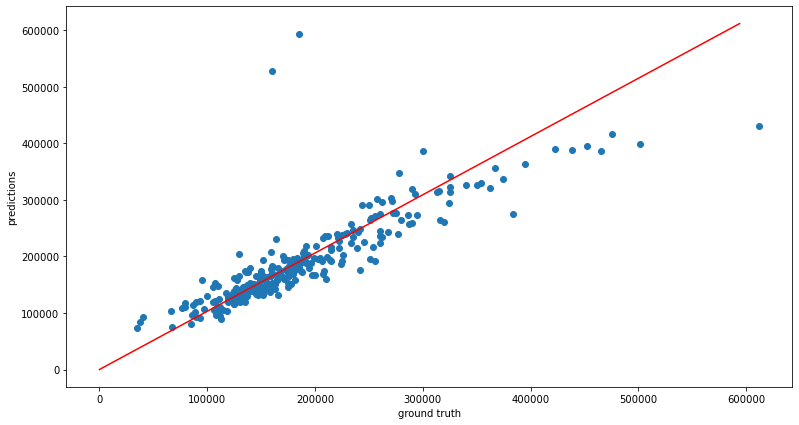

In [56]:
# visualize accuracy:
y_ts, preds = result[r2Idx][4], result[r2Idx][5]
plt.figure(figsize=(13,7))
plt.scatter(y_ts, preds)
plt.plot([0, max(preds)], [0, max(y_ts)], color="r")
plt.xlabel("ground truth")
plt.ylabel("predictions");

## Target encoder

In [73]:
df = pd.concat([df[numericals], df[objectives], df[target]], axis=1)

In [94]:
result = []
for algo in algos:
    evaluate_model(algo, df, ce.TargetEncoder)

model LinearRegression metrics:
MSE: 2769723900.7500453
MAE: 23078.024894879596
r2: 0.5703843147395674
----------------------------------------------------------------
model DecisionTreeRegressor metrics:
MSE: 3253125462.869863
MAE: 27780.73287671233
r2: 0.49540323330042835
----------------------------------------------------------------
model SVR metrics:
MSE: 6902506317.138654
MAE: 55895.348608068416
r2: -0.0706572523885669
----------------------------------------------------------------
model RandomForestRegressor metrics:
MSE: 1857461275.9742115
MAE: 20619.830719178084
r2: 0.7118866257007493
----------------------------------------------------------------
model SGDRegressor metrics:
MSE: 2776835169.646052
MAE: 23258.518969890054
r2: 0.5692812760363228
----------------------------------------------------------------
model Lasso metrics:
MSE: 2774373255.1468387
MAE: 23081.20700059591
r2: 0.569663146981779
----------------------------------------------------------------
model XGBRegre

In [95]:
mseIdx = np.argmin([result[i][1] for i in range(len(result))])
r2Idx = np.argmax([result[i][3] for i in range(len(result))])
print(f"best mse score of {int(result[mseIdx][1])} goes to {result[mseIdx][0]}")
print(f"best r2 score of {round(result[r2Idx][3], 2)} goes to {result[mseIdx][0]}")

best mse score of 1857461275 goes to RandomForestRegressor
best r2 score of 0.71 goes to RandomForestRegressor


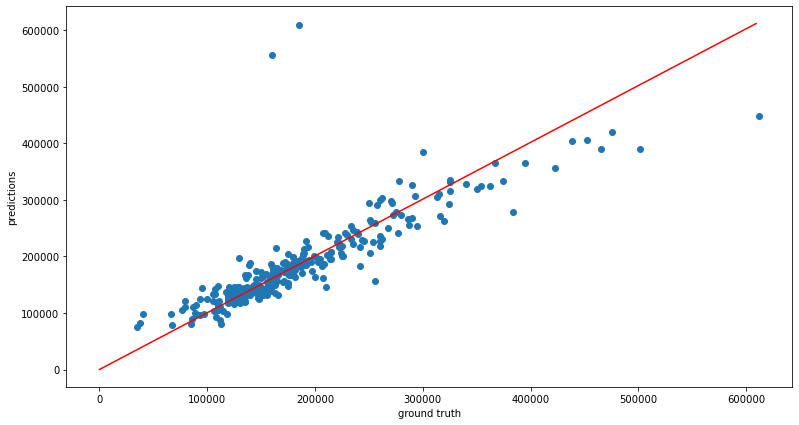

In [96]:
# visualize accuracy:
y_ts, preds = result[r2Idx][4], result[r2Idx][5]
plt.figure(figsize=(13,7))
plt.scatter(y_ts, preds)
plt.plot([0, max(preds)], [0, max(y_ts)], color="r")
plt.xlabel("ground truth")
plt.ylabel("predictions");

## CatBoost encoder

In [90]:
df = pd.concat([df[numericals], df[objectives], df[target]], axis=1)

In [97]:
result = []
for algo in algos:
    evaluate_model(algo, df, ce.cat_boost.CatBoostEncoder)

model LinearRegression metrics:
MSE: 3125136987.7801003
MAE: 23448.6795542724
r2: 0.5152557017779672
----------------------------------------------------------------
model DecisionTreeRegressor metrics:
MSE: 3295130235.952055
MAE: 29939.527397260274
r2: 0.48888781515097746
----------------------------------------------------------------
model SVR metrics:
MSE: 6902793405.598605
MAE: 55896.44930540628
r2: -0.07070178307461084
----------------------------------------------------------------
model RandomForestRegressor metrics:
MSE: 1731984882.9000535
MAE: 20881.30565068493
r2: 0.7313494416803363
----------------------------------------------------------------
model SGDRegressor metrics:
MSE: 2939248674.0451193
MAE: 22853.241597540957
r2: 0.5440890938953309
----------------------------------------------------------------
model Lasso metrics:
MSE: 3125860963.4874787
MAE: 23443.48890851444
r2: 0.5151434049098378
----------------------------------------------------------------
model XGBRegre

In [99]:
mseIdx = np.argmin([result[i][1] for i in range(len(result))])
r2Idx = np.argmax([result[i][3] for i in range(len(result))])
print(f"best mse score of {int(result[mseIdx][1])} goes to {result[mseIdx][0]}")
print(f"best r2 score of {round(result[r2Idx][3], 2)} goes to {result[mseIdx][0]}")

best mse score of 1731984882 goes to RandomForestRegressor
best r2 score of 0.73 goes to RandomForestRegressor


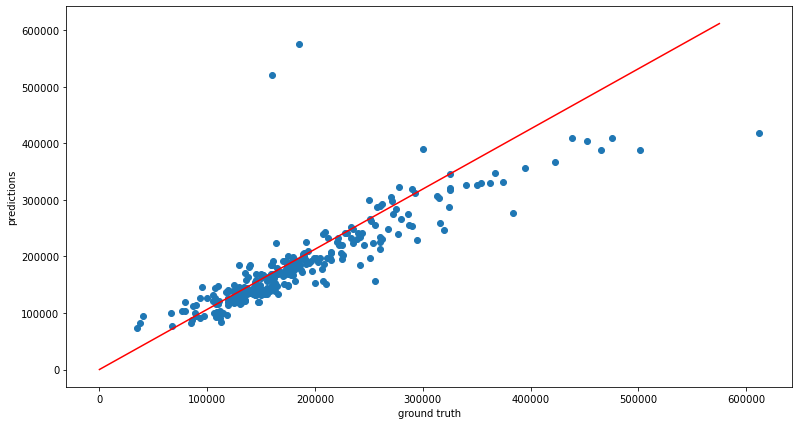

In [100]:
# visualize accuracy:
y_ts, preds = result[r2Idx][4], result[r2Idx][5]
plt.figure(figsize=(13,7))
plt.scatter(y_ts, preds)
plt.plot([0, max(preds)], [0, max(y_ts)], color="r")
plt.xlabel("ground truth")
plt.ylabel("predictions");

$\Sigma$ : CatBoost encoder performed indeed better, but to make a more profound conclusion it is required to:

- perform deeper feature processing and engineering

- perform hyperparameters tuning for the selected models (in particular, xgboost is quite sensitive to the params and might perform much better)